In [ ]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00



Importing libraries

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')


 Importing Dataset

In [ ]:
!pip install datasets



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import datasets

# Load the dataset
dataset = datasets.load_dataset('json', data_files='/content/data.jsonl')

# Access the dataset
print(dataset)


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})

In [ ]:
import datasets

# Load the dataset from the file paths
dataset = datasets.load_dataset('json', data_files={'train': '/content/train.jsonl',
                                                    'validation': '/content/validation.jsonl',
                                                    'test': '/content/test.jsonl'})

# Access the splits
train = dataset['train']
val = dataset['validation']
test = dataset['test']


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something', 0)

Tokenizing Tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


Padding and Truncating Sequences

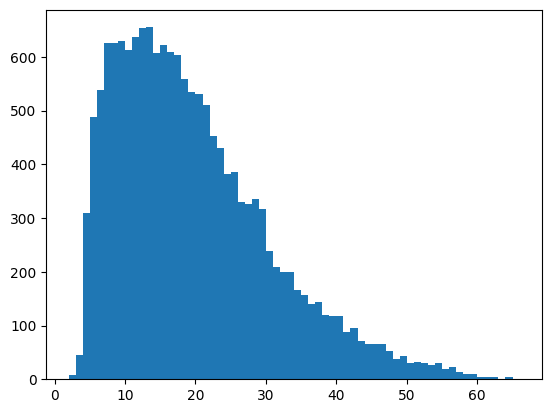

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Preparing Labels

In [ ]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


Creating Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Model

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', 4)

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 39s 62ms/step - loss: 1.3010 - accuracy: 0.4771 - val_loss: 0.7426 - val_accuracy: 0.7305
Epoch 2/15
500/500 [==============================] - 30s 60ms/step - loss: 0.4926 - accuracy: 0.8243 - val_loss: 0.5235 - val_accuracy: 0.8200
Epoch 3/15
500/500 [==============================] - 29s 58ms/step - loss: 0.3073 - accuracy: 0.8891 - val_loss: 0.4434 - val_accuracy: 0.8490
Epoch 4/15
500/500 [==============================] - 29s 58ms/step - loss: 0.2289 - accuracy: 0.9174 - val_loss: 0.4899 - val_accuracy: 0.8460
Epoch 5/15
500/500 [==============================] - 31s 61ms/step - loss: 0.1856 - accuracy: 0.9289 - val_loss: 0.4039 - val_accuracy: 0.8675
Epoch 6/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1416 - accuracy: 0.9475 - val_loss: 0.4259 - val_accuracy: 0.8740
Epoch 7/15
500/500 [==============================] - 29s 58ms/step - loss: 0.1116 - accuracy: 0.9611 - val_loss: 0.4138 - val_accuracy:

Evaluating the Model

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
eval = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 15ms/step - loss: 0.4532 - accuracy: 0.8825


In [ ]:
import numpy as np
import random

# Assuming 'model' is your Keras model
for a in range(0, 10):
    i = random.randint(0, len(test_labels) - 1)

    print('Tweet:', test_tweets[i])
    print('Actual Emotion:', index_to_classes[test_labels[i]])

    # Get raw output probabilities of the model
    probabilities = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

    # Determine the predicted class based on probabilities
    predicted_class_index = np.argmax(probabilities)
    predicted_emotion = index_to_classes.get(predicted_class_index)

    print('Predicted Emotion:', predicted_emotion, '\n')


Tweet: i was so focused on my heavy breathing my even strides the drops of sweat on my forehead that i forgot to feel socially awkward
Actual Emotion: 0
1/1 [==============================] - 0s 33ms/step
Predicted Emotion: 0 

Tweet: i feel as though most people will find it quite pleasant
Actual Emotion: 1
1/1 [==============================] - 0s 30ms/step
Predicted Emotion: 1 

Tweet: i can feel the rebellious spirit already
Actual Emotion: 3
1/1 [==============================] - 0s 28ms/step
Predicted Emotion: 3 

Tweet: i could feel how much slower i was on the treadmill but the pace was pleasant and after six days of relative inactivity i was just happy to be running again
Actual Emotion: 1
1/1 [==============================] - 0s 29ms/step
Predicted Emotion: 1 

Tweet: i read it at a time amp place where i was feeling less than perfect
Actual Emotion: 1
1/1 [==============================] - 0s 28ms/step
Predicted Emotion: 1 

Tweet: i feel scared anxious
Actual Emotion: 4
1/

In [ ]:
import numpy as np

# Assuming 'model' is your Keras model
# Assuming 'test_sequences' is your input sequences for testing
# Assuming 'test_labels' is your ground truth labels for testing
predictions_probabilities = model.predict(test_sequences)
predictions = np.argmax(predictions_probabilities, axis=1)

# Now 'predictions' contains the predicted class indices
# You can compare 'predictions' with 'test_labels' to evaluate the model performance


63/63 [==============================] - 1s 17ms/step


63/63 [==============================] - 2s 38ms/step


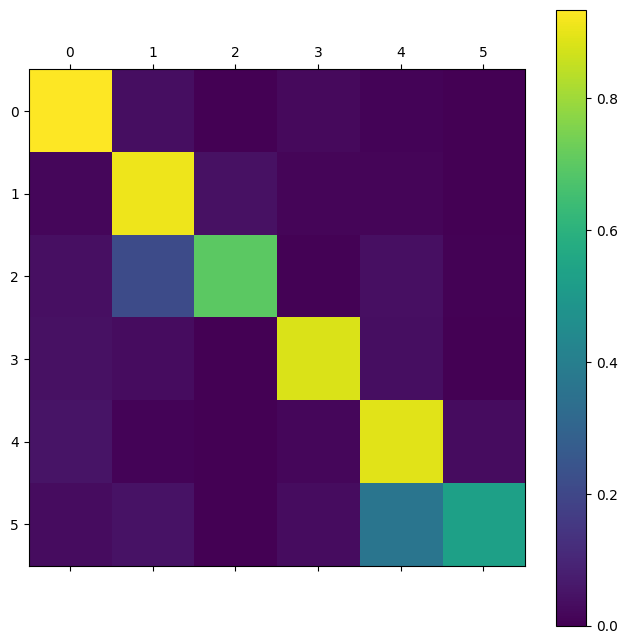

In [ ]:
# Obtain predicted class labels using your model
preds = model.predict(test_sequences)
preds = np.argmax(preds, axis=1)

# Now that preds is defined, you can call the show_confusion_matrix function
show_confusion_matrix(test_labels, preds, list(classes))


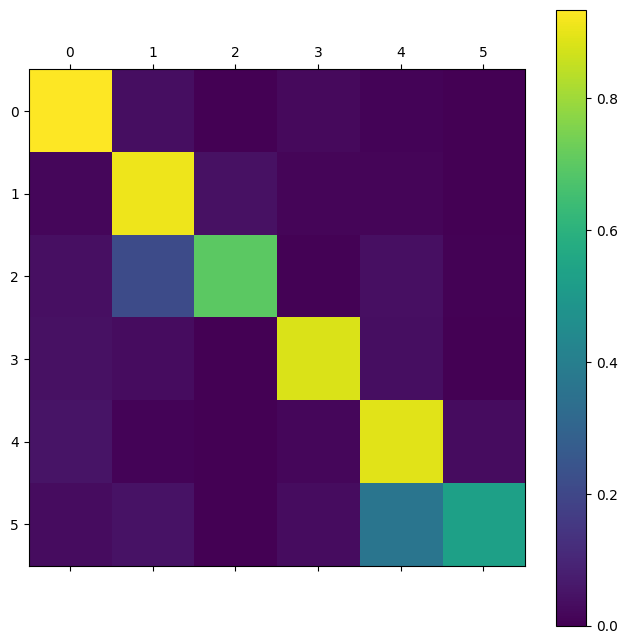

In [ ]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

show_confusion_matrix(test_labels, preds, list(classes))